In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Propose(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Propose(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

03/05/2019 14:07:40 ELBO=-4.08261017e+02 at epoch 1
03/05/2019 14:07:40 ELBO=-3.12791351e+02 at epoch 2
03/05/2019 14:07:41 ELBO=-4.41842865e+02 at epoch 3
03/05/2019 14:07:41 ELBO=-4.37440704e+02 at epoch 4
03/05/2019 14:07:41 ELBO=-4.09188446e+02 at epoch 5
03/05/2019 14:07:41 ELBO=-4.26470428e+02 at epoch 6
03/05/2019 14:07:41 ELBO=-4.07842133e+02 at epoch 7
03/05/2019 14:07:42 ELBO=-4.22457306e+02 at epoch 8
03/05/2019 14:07:42 ELBO=-4.16025604e+02 at epoch 9
03/05/2019 14:07:42 ELBO=-4.16411041e+02 at epoch 10
03/05/2019 14:07:42 ELBO=-4.01039917e+02 at epoch 11
03/05/2019 14:07:42 ELBO=-2.41355499e+02 at epoch 12
03/05/2019 14:07:42 ELBO=-3.93563293e+02 at epoch 13
03/05/2019 14:07:43 ELBO=-4.09495850e+02 at epoch 14
03/05/2019 14:07:43 ELBO=-3.90235077e+02 at epoch 15
03/05/2019 14:07:43 ELBO=-3.77425232e+02 at epoch 16
03/05/2019 14:07:43 ELBO=-4.10347961e+02 at epoch 17
03/05/2019 14:07:43 ELBO=-2.06633911e+02 at epoch 18
03/05/2019 14:07:44 ELBO=-3.83962189e+02 at epoch 19
03

Epoch   253: reducing learning rate of group 0 to 5.0000e-02.


03/05/2019 14:08:29 ELBO=-8.50119095e+01 at epoch 256
03/05/2019 14:08:29 ELBO=-5.80436440e+01 at epoch 257
03/05/2019 14:08:29 ELBO=-1.34312500e+02 at epoch 258
03/05/2019 14:08:29 ELBO=-1.32864319e+02 at epoch 259
03/05/2019 14:08:30 ELBO=-1.33861099e+02 at epoch 260
03/05/2019 14:08:30 ELBO=-4.19536018e+01 at epoch 261
03/05/2019 14:08:30 ELBO=-1.24572304e+02 at epoch 262
03/05/2019 14:08:30 ELBO=-1.09258636e+02 at epoch 263
03/05/2019 14:08:30 ELBO=-6.20464478e+01 at epoch 264
03/05/2019 14:08:30 ELBO=-1.16966576e+02 at epoch 265
03/05/2019 14:08:31 ELBO=-1.19149445e+02 at epoch 266
03/05/2019 14:08:31 ELBO=-7.08368073e+01 at epoch 267
03/05/2019 14:08:31 ELBO=-1.22853317e+02 at epoch 268
03/05/2019 14:08:31 ELBO=-1.16620613e+02 at epoch 269
03/05/2019 14:08:31 ELBO=-1.27194534e+02 at epoch 270
03/05/2019 14:08:31 ELBO=-9.71618805e+01 at epoch 271
03/05/2019 14:08:32 ELBO=-1.01420609e+02 at epoch 272
03/05/2019 14:08:32 ELBO=-1.28232651e+02 at epoch 273
03/05/2019 14:08:32 ELBO=-1.

Epoch   387: reducing learning rate of group 0 to 2.5000e-02.


03/05/2019 14:08:54 ELBO=-1.04983490e+02 at epoch 390
03/05/2019 14:08:54 ELBO=-1.07775780e+02 at epoch 391
03/05/2019 14:08:55 ELBO=-1.04558418e+02 at epoch 392
03/05/2019 14:08:55 ELBO=-1.09539207e+02 at epoch 393
03/05/2019 14:08:55 ELBO=-1.01129173e+02 at epoch 394
03/05/2019 14:08:55 ELBO=-8.35280838e+01 at epoch 395
03/05/2019 14:08:55 ELBO=-4.21019440e+01 at epoch 396
03/05/2019 14:08:55 ELBO=-9.38953705e+01 at epoch 397
03/05/2019 14:08:56 ELBO=-1.02329460e+02 at epoch 398
03/05/2019 14:08:56 ELBO=-9.54284821e+01 at epoch 399
03/05/2019 14:08:56 ELBO=-8.80438843e+01 at epoch 400
03/05/2019 14:08:56 ELBO=-7.98666992e+01 at epoch 401
03/05/2019 14:08:57 ELBO=-5.26856689e+01 at epoch 402
03/05/2019 14:08:57 ELBO=-1.01773140e+02 at epoch 403
03/05/2019 14:08:57 ELBO=-9.67710876e+01 at epoch 404
03/05/2019 14:08:57 ELBO=-8.70297089e+01 at epoch 405
03/05/2019 14:08:57 ELBO=-7.52329330e+01 at epoch 406
03/05/2019 14:08:57 ELBO=-7.13076401e+01 at epoch 407
03/05/2019 14:08:58 ELBO=-1.

Epoch   488: reducing learning rate of group 0 to 1.2500e-02.


03/05/2019 14:09:13 ELBO=-8.20879517e+01 at epoch 491
03/05/2019 14:09:13 ELBO=-8.40187836e+01 at epoch 492
03/05/2019 14:09:13 ELBO=-8.35695190e+01 at epoch 493
03/05/2019 14:09:13 ELBO=-4.00205536e+01 at epoch 494
03/05/2019 14:09:14 ELBO=-8.32417908e+01 at epoch 495
03/05/2019 14:09:14 ELBO=-7.31556244e+01 at epoch 496
03/05/2019 14:09:14 ELBO=-8.50913544e+01 at epoch 497
03/05/2019 14:09:14 ELBO=-8.91125488e+01 at epoch 498
03/05/2019 14:09:14 ELBO=-7.54627991e+01 at epoch 499
03/05/2019 14:09:15 ELBO=-6.07990723e+01 at epoch 500
03/05/2019 14:09:15 ELBO=-8.14992294e+01 at epoch 501
03/05/2019 14:09:15 ELBO=-7.61061478e+01 at epoch 502
03/05/2019 14:09:15 ELBO=-4.24673615e+01 at epoch 503
03/05/2019 14:09:15 ELBO=-6.16974564e+01 at epoch 504
03/05/2019 14:09:15 ELBO=-4.36303635e+01 at epoch 505
03/05/2019 14:09:16 ELBO=-7.96002808e+01 at epoch 506
03/05/2019 14:09:16 ELBO=-6.28740616e+01 at epoch 507
03/05/2019 14:09:16 ELBO=-7.53299561e+01 at epoch 508
03/05/2019 14:09:16 ELBO=-8.

Epoch   703: reducing learning rate of group 0 to 6.2500e-03.


03/05/2019 14:09:52 ELBO=-8.83818054e+01 at epoch 706
03/05/2019 14:09:52 ELBO=-5.35813026e+01 at epoch 707
03/05/2019 14:09:52 ELBO=-7.34316101e+01 at epoch 708
03/05/2019 14:09:52 ELBO=-4.75731468e+01 at epoch 709
03/05/2019 14:09:52 ELBO=-4.74949303e+01 at epoch 710
03/05/2019 14:09:53 ELBO=-7.40522995e+01 at epoch 711
03/05/2019 14:09:53 ELBO=-8.61958694e+01 at epoch 712
03/05/2019 14:09:53 ELBO=-8.08583221e+01 at epoch 713
03/05/2019 14:09:53 ELBO=-7.13082199e+01 at epoch 714
03/05/2019 14:09:53 ELBO=-7.93375244e+01 at epoch 715
03/05/2019 14:09:53 ELBO=-8.59141922e+01 at epoch 716
03/05/2019 14:09:54 ELBO=-7.48914642e+01 at epoch 717
03/05/2019 14:09:54 ELBO=-7.04135513e+01 at epoch 718
03/05/2019 14:09:54 ELBO=-6.75312653e+01 at epoch 719
03/05/2019 14:09:54 ELBO=-2.84817867e+01 at epoch 720
03/05/2019 14:09:54 ELBO=-5.79689598e+01 at epoch 721
03/05/2019 14:09:55 ELBO=-5.79308929e+01 at epoch 722
03/05/2019 14:09:55 ELBO=-7.07144470e+01 at epoch 723
03/05/2019 14:09:55 ELBO=-4.

Epoch   804: reducing learning rate of group 0 to 3.1250e-03.


03/05/2019 14:10:10 ELBO=-8.15711594e+01 at epoch 807
03/05/2019 14:10:11 ELBO=-8.46225281e+01 at epoch 808
03/05/2019 14:10:11 ELBO=-7.52328262e+01 at epoch 809
03/05/2019 14:10:11 ELBO=-5.65192909e+01 at epoch 810
03/05/2019 14:10:11 ELBO=-6.88932037e+01 at epoch 811
03/05/2019 14:10:11 ELBO=-7.00439987e+01 at epoch 812
03/05/2019 14:10:12 ELBO=-4.92716179e+01 at epoch 813
03/05/2019 14:10:12 ELBO=-8.75200577e+01 at epoch 814
03/05/2019 14:10:12 ELBO=-6.40501099e+01 at epoch 815
03/05/2019 14:10:12 ELBO=-6.39560051e+01 at epoch 816
03/05/2019 14:10:12 ELBO=-7.04135132e+01 at epoch 817
03/05/2019 14:10:13 ELBO=-8.34679337e+01 at epoch 818
03/05/2019 14:10:13 ELBO=-5.42508049e+01 at epoch 819
03/05/2019 14:10:13 ELBO=-8.52062149e+01 at epoch 820
03/05/2019 14:10:13 ELBO=-7.47366180e+01 at epoch 821
03/05/2019 14:10:13 ELBO=-7.13020172e+01 at epoch 822
03/05/2019 14:10:14 ELBO=-5.76496506e+01 at epoch 823
03/05/2019 14:10:14 ELBO=-6.89430161e+01 at epoch 824
03/05/2019 14:10:14 ELBO=-5.

Epoch   927: reducing learning rate of group 0 to 1.5625e-03.


03/05/2019 14:10:33 ELBO=-8.29498749e+01 at epoch 930
03/05/2019 14:10:33 ELBO=-6.31358643e+01 at epoch 931
03/05/2019 14:10:33 ELBO=-5.87756310e+01 at epoch 932
03/05/2019 14:10:34 ELBO=-5.12194901e+01 at epoch 933
03/05/2019 14:10:34 ELBO=-8.27629547e+01 at epoch 934
03/05/2019 14:10:34 ELBO=-4.94997406e+01 at epoch 935
03/05/2019 14:10:34 ELBO=-7.01466064e+01 at epoch 936
03/05/2019 14:10:34 ELBO=-6.80104370e+01 at epoch 937
03/05/2019 14:10:35 ELBO=-7.17853699e+01 at epoch 938
03/05/2019 14:10:35 ELBO=-6.47509308e+01 at epoch 939
03/05/2019 14:10:35 ELBO=-7.56362839e+01 at epoch 940
03/05/2019 14:10:35 ELBO=-6.71443787e+01 at epoch 941
03/05/2019 14:10:35 ELBO=-7.06101913e+01 at epoch 942
03/05/2019 14:10:36 ELBO=-7.68425598e+01 at epoch 943
03/05/2019 14:10:36 ELBO=-6.94799118e+01 at epoch 944
03/05/2019 14:10:36 ELBO=-6.38892555e+01 at epoch 945
03/05/2019 14:10:36 ELBO=-7.03143768e+01 at epoch 946
03/05/2019 14:10:36 ELBO=-4.66902885e+01 at epoch 947
03/05/2019 14:10:36 ELBO=-6.

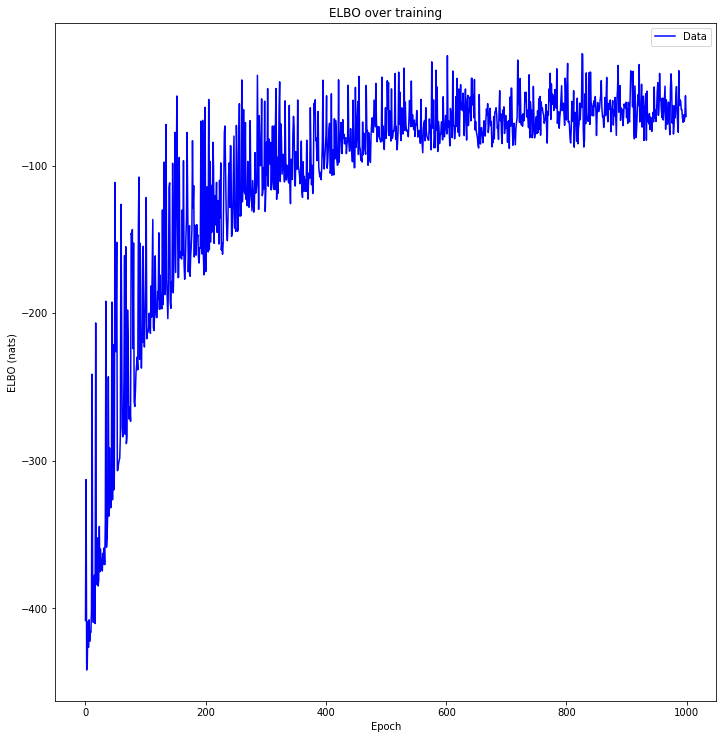

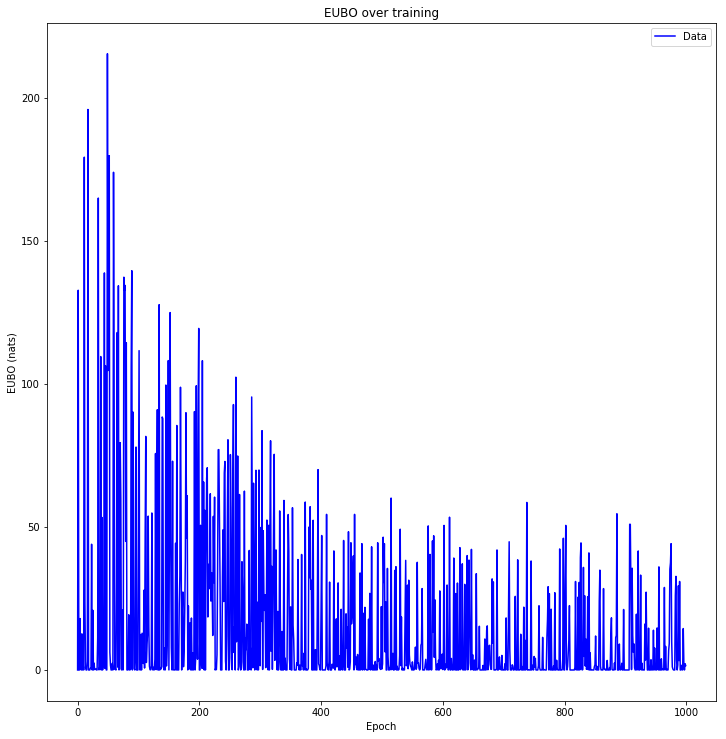

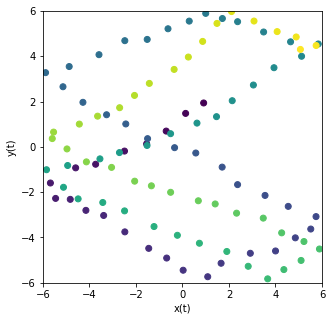

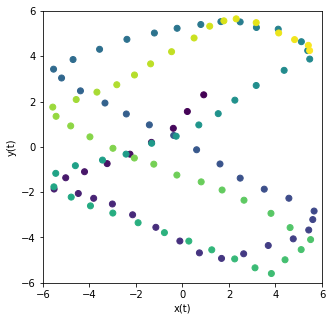

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, (elbos, eubos) = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, bound='elbo',
        patience=100,
    )
    utils.plot_evidence_bounds(elbos.detach().numpy(), True)
    utils.plot_evidence_bounds(eubos.detach().numpy(), False)
    
    bouncing_ball_posterior = mcmc.resample_move_smc(importance_sampler, moves=5)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-1.7902, -1.8591], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.4069, -2.5403], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.7371,  0.0000],\n        [ 0.0236, -1.9128]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([0.8753, 2.1304], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-1.0848, -1.4816], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.2691, -2.4596], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[-0.8329, -0.6842],\n        [-0.8797, -0.5568],\n        [-0.9528, -0.4142],\n        [-1.1161, -0.4916],\n        [-0.9376, -0.3397],\n        [-1.0371, -0.5574],\n        [-0.8587, -0.5407],\n        [ 0.6896, -0.2612],\n        [ 0.6781, -0.4107],\n        [ 0.7539, -0.3549],\n        [ 0.9039, -0.6148],\n        [ 0.9601, -0.6442],\n        [ 0.8044, -0.4630],\n        [ 0.7693, -0.4317],\n        [ 0.9379, -0.1627],\n        [ 0.7216,  0.3579],\n        [ 1.1073,  0.3766],\n  

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Position at time 0 tensor([0.9118, 1.9397])
Inferred position at time 0 tensor([0.9153, 2.2997])
MSE at time 0 tensor(0.1297)
Position at time 1 tensor([0.1367, 1.4792])
Inferred position at time 1 tensor([0.2109, 1.5628])
MSE at time 1 tensor(0.0125)
Position at time 2 tensor([-0.6990,  0.6983])
Inferred position at time 2 tensor([-0.3927,  0.8204])
MSE at time 2 tensor(0.1087)
Position at time 3 tensor([-1.5409,  0.1345])
Inferred position at time 3 tensor([-1.3335,  0.2000])
MSE at time 3 tensor(0.0473)
Position at time 4 tensor([-2.4919, -0.1842])
Inferred position at time 4 tensor([-2.2561, -0.3213])
MSE at time 4 tensor(0.0745)
Position at time 5 tensor([-3.7338, -0.7656])
Inferred position at time 5 tensor([-3.2388, -0.7379])
MSE at time 5 tensor(0.2458)
Position at time 6 tensor([-4.5940, -0.9251])
Inferred position at time 6 tensor([-4.2121, -1.0959])
MSE at time 6 tensor(0.1749)
Position at time 7 tensor([-5.6793, -1.5939])
Inferred position at time 7 tensor([-5.0213, -1.3629

In [24]:
bouncing_ball_smc = importance.smc(importance_sampler)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [25]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Inferred position at time 0 tensor([0.9392, 2.0308])
MSE at time 0 tensor(0.0091)
Inferred position at time 1 tensor([0.0779, 1.0098])
MSE at time 1 tensor(0.2238)
Inferred position at time 2 tensor([-0.7346,  0.3179])
MSE at time 2 tensor(0.1459)
Inferred position at time 3 tensor([-1.7670, -0.2644])
MSE at time 3 tensor(0.2102)
Inferred position at time 4 tensor([-2.7251, -0.7611])
MSE at time 4 tensor(0.3873)
Inferred position at time 5 tensor([-3.8124, -1.2231])
MSE at time 5 tensor(0.2154)
Inferred position at time 6 tensor([-4.7457, -1.6820])
MSE at time 6 tensor(0.5958)
Inferred position at time 7 tensor([-5.2932, -2.1775])
MSE at time 7 tensor(0.4896)
Inferred position at time 8 tensor([-5.4438, -2.8739])
MSE at time 8 tensor(0.3603)
Inferred position at time 9 tensor([-4.6102, -3.0753])
MSE at time 9 tensor(0.6236)
Inferred position at time 10 tensor([-3.7766, -3.4629])
MSE at time 10 tensor(0.5786)
Inferred position at time 11 tensor([-2.9940, -3.8332])
MSE at time 11 tensor(

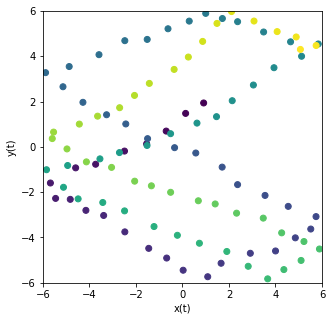

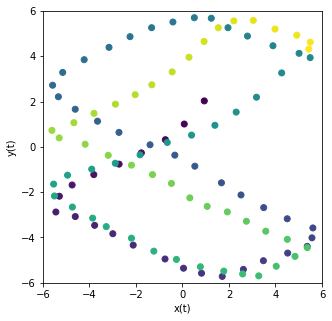

In [26]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)